<a href="https://colab.research.google.com/github/lilyzhizhou/datathon-3/blob/main/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applying XGBoost to processed dataset

### Preparation

In [24]:
#import libraries

#!pip install category_encoders

import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

warnings.filterwarnings('ignore')

In [4]:
# Import Pre-Diabetes Data
from google.colab import files
uploaded = files.upload()
datapd = pd.read_csv('datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

datapd.head()

Saving datapd.csv to datapd.csv
(6414, 11)


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [8]:
#check dataset shape, variable types, and missing values
print(datapd.shape)
print(datapd.dtypes)
print(datapd.isnull().sum())
#there are 152 missing values for TG

print((datapd['Total_Cholesterol'].isnull().sum() / len(datapd)) * 100)
#this is around 2% of data

(6414, 11)
predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
dtype: object
predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64
2.369816027439975


In [14]:
#Imputation of missing values
#median used to be more resistant to influence of any outliers
datapd['Total_Cholesterol'].fillna(datapd['Total_Cholesterol'].median(), inplace = True)

In [15]:
#specify columns

# Define the column that will be used as the target for modeling or analysis
target_column = 'predm'

# List of columns that contain categorical data
categorical_columns = ['Depression','HTN', 'OA','COPD','corstrd_bin','htnmed_bin','Sex']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in datapd.columns if c not in categorical_columns and c != target_column]

### Set up model

In [16]:
# Splitting the data into 70% training and 30% testing
train = datapd.sample(frac=0.7, random_state=10)
test = datapd.drop(train.index)

# Initializing the Gradient Boosting Classifier with specified parameters
xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Creating a Pipeline:
# only contains Gradient Boosting model, because no column transformations are required
model = Pipeline([('xg_boost', xgboost)])

### Training and initial evaluation

In [17]:
# Training the Gradient Boosting model on the training dataset
model = model.fit(train.drop('predm', axis=1), train['predm']) #using pre-split data

# Predicting on the training dataset and computing the accuracy
Y_pred = model.predict(train.drop('predm', axis=1))
accuracy_score(train['predm'], Y_pred)

# Predicting on the test dataset and computing the accuracy
Y_pred = model.predict(test.drop('predm', axis=1))
accuracy_score(test['predm'], Y_pred)
#0.638, quite low

0.6382536382536382

### Hyperparamater tuning with grid search

In [19]:
# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "xg_boost__n_estimators" : [100, 200], #total number of trees/boosting rounds
    "xg_boost__max_depth" : [1, 3, 5], #max depth of one tree
    "xg_boost__min_samples_leaf" : [20,30,40], #min samples to be a leaf
    "xg_boost__learning_rate" : [.1,  .2]
}
  #this took so long to run

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=5)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Fitting the GridSearchCV on the training data
random_search.fit(train.drop('predm', axis=1), train['predm'])

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xg_boost__learning_rate,param_xg_boost__max_depth,param_xg_boost__min_samples_leaf,param_xg_boost__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.621275,0.08727,0.005504,0.001016,0.1,3,20,100,"{'xg_boost__learning_rate': 0.1, 'xg_boost__ma...",0.629176,0.650334,0.63029,0.650334,0.681514,0.64833,0.018982,1


In [20]:
# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

{'xg_boost__learning_rate': 0.1,
 'xg_boost__max_depth': 3,
 'xg_boost__min_samples_leaf': 20,
 'xg_boost__n_estimators': 100}

In [21]:
#Run GridSearchCV again, using new parameter options around best params from first GridSearch
param_dist = {
    "xg_boost__n_estimators" : [80, 100], #total number of trees/boosting rounds
    "xg_boost__max_depth" : [2, 3], #max depth of one tree
    "xg_boost__min_samples_leaf" : [15,20], #min samples to be a leaf
    "xg_boost__learning_rate" : [.1]
}
  #less options to reduce run time

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=5)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Fitting the GridSearchCV on the training data
random_search.fit(train.drop('predm', axis=1), train['predm'])

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xg_boost__learning_rate,param_xg_boost__max_depth,param_xg_boost__min_samples_leaf,param_xg_boost__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.472111,0.008129,0.004361,0.000111,0.1,3,20,100,"{'xg_boost__learning_rate': 0.1, 'xg_boost__ma...",0.629176,0.650334,0.63029,0.650334,0.681514,0.64833,0.018982,1


In [22]:
# Retrieve the best hyperparameters after Grid Search #2
random_search.best_params_
#parameters are the same

{'xg_boost__learning_rate': 0.1,
 'xg_boost__max_depth': 3,
 'xg_boost__min_samples_leaf': 20,
 'xg_boost__n_estimators': 100}

### Refit model with optimal hyperparameters

In [23]:
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(train.drop('predm', axis=1), train['predm'])

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(train.drop('predm', axis=1))
train_accuracy = accuracy_score(train['predm'], Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_pred = model.predict(test.drop('predm', axis=1))
test_accuracy = accuracy_score(test['predm'], Y_pred)
print(test_accuracy)
#0.633 did not improve lmao

0.6948775055679287
0.6335758835758836


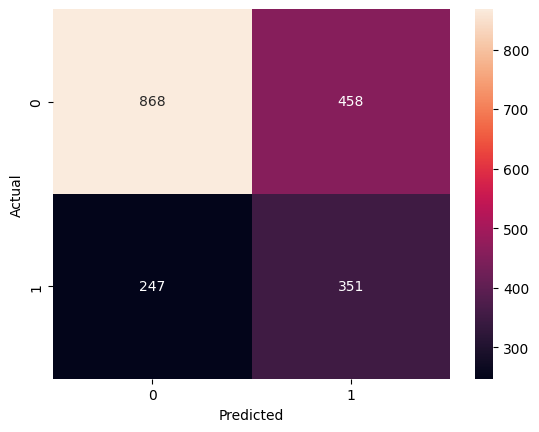

In [27]:
#more evaluation metrics
Y = test['predm']
conf_matrix = confusion_matrix(Y_pred, Y)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()